# Derivatives

This notebook aims at comparing different methods to implement the FirstDerivative operator:

1. fancy indexing (as done so far in Derivative1D)
2. using Convolve1D

as well as considering different kind of derivatives:

1. Forward
2. Centered
3. Backward

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import SplitBregman as SplitBregman_f

## 1D

True
True


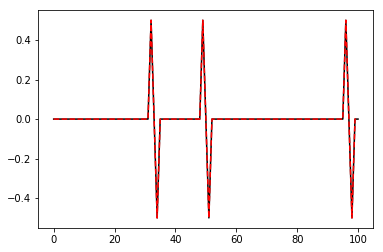

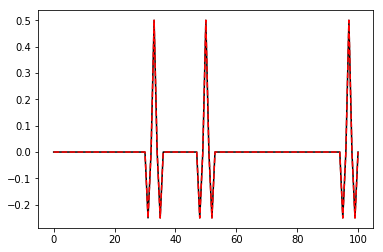

In [2]:
nx = 101
x = np.zeros(nx)
x[nx//2] = 1
x[nx//3] = 1
x[nx-4] = 1

Dop = FirstDerivative(nx, edge=True)
Dconvop = Convolve1D(nx, np.array([0.5, 0, -0.5]), offset=1)

y = Dop*x
yconv = Dconvop*x

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

plt.figure()
plt.plot(y, 'k')
plt.plot(yconv, '--r')

plt.figure()
plt.plot(xadj, 'k')
plt.plot(xadjconv, '--r');

In [3]:
%timeit -n 100 -r 3 Dop.matvec(x)
%timeit -n 100 -r 3 Dconvop.matvec(x)

%timeit -n 100 -r 3 Dop.rmatvec(y)
%timeit -n 100 -r 3 Dconvop.rmatvec(y)

27.8 µs ± 1.27 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
14.6 µs ± 3.97 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
31.4 µs ± 6.65 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
35.6 µs ± 8.03 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


## 2D

In [4]:
nt, nx = 501, 1001 
x = np.zeros((nt, nx))
x[nt//2] = 1
x[nt//3] = 1
x[nt-4] = 1

Dop = FirstDerivative(nx*nt, dims=(nt, nx), dir=0)
Dconvop = Convolve1D(nx*nt, np.array([0.5, 0, -0.5]), dims=(nt, nx), offset=1, dir=0)

y = Dop*x.ravel()
yconv = Dconvop*x.ravel()

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

True
True


In [5]:
%timeit -n 10 -r 3 Dop.matvec(x.ravel())
%timeit -n 10 -r 3 Dconvop.matvec(x.ravel())

%timeit -n 10 -r 3 Dop.rmatvec(y)
%timeit -n 10 -r 3 Dconvop.rmatvec(y)

7.33 ms ± 134 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
24 ms ± 383 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
9.78 ms ± 55.9 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
26.7 ms ± 176 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [6]:
nt, nx = 501, 1001 
x = np.zeros((nt, nx))
x[:, nx//2] = 1
x[:, nx//3] = 1
x[:, nx-4] = 1

Dop = FirstDerivative(nx*nt, dims=(nt, nx), dir=1)
Dconvop = Convolve1D(nx*nt, np.array([0.5, 0, -0.5]), dims=(nt, nx), offset=1, dir=1)

y = Dop*x.ravel()
yconv = Dconvop*x.ravel()

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

True
True


In [7]:
%timeit -n 10 -r 3 Dop.matvec(x.ravel())
%timeit -n 10 -r 3 Dconvop.matvec(x.ravel())

%timeit -n 10 -r 3 Dop.rmatvec(y)
%timeit -n 10 -r 3 Dconvop.rmatvec(y)

16.1 ms ± 2.05 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
22.1 ms ± 277 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
19.5 ms ± 2.11 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
22.4 ms ± 537 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


## 3D

In [8]:
nt, nx, ny = 101, 201, 101
x = np.zeros((nt, nx, ny))
x[...,ny//2] = 1
x[...,ny//3] = 1
x[...,ny-4] = 1

Dop = FirstDerivative(nx*nt*ny, dims=(nt, nx, ny), dir=2)
Dconvop = Convolve1D(nx*nt*ny, np.array([0.5, 0, -0.5]), 
                     dims=(nt, nx, ny), offset=1, dir=2)

y = Dop*x.ravel()
yconv = Dconvop*x.ravel()

xadj = Dop.H*y
xadjconv = Dconvop.H*y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

True
True


In [9]:
%timeit -n 10 -r 3 Dop.matvec(x.ravel())
%timeit -n 10 -r 3 Dconvop.matvec(x.ravel())

%timeit -n 10 -r 3 Dop.rmatvec(y)
%timeit -n 10 -r 3 Dconvop.rmatvec(y)

94 ms ± 12 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
95.4 ms ± 3.26 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
109 ms ± 786 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
99.8 ms ± 810 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


## 1D forward

Dot test passed, v^T(Opu)=-11.542379 - u^T(Op^Tv)=-11.542379
True
True
True
True


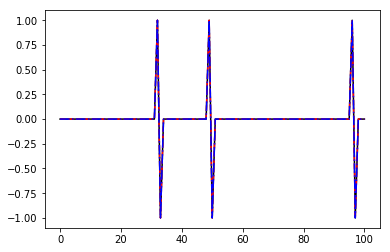

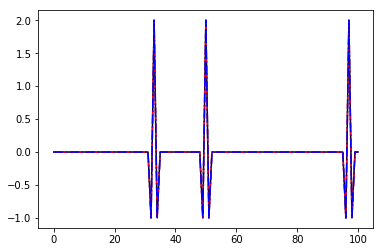

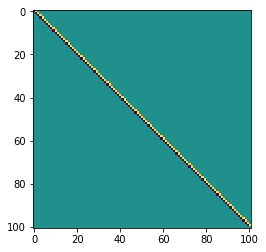

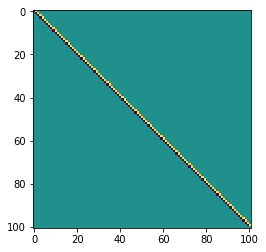

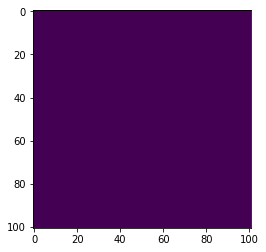

In [37]:
nx = 101
x = np.zeros(nx)
x[nx//2] = 1
x[nx//3] = 1
x[nx-4] = 1

Dop = FirstDerivative(nx, kind='forward')
Dconvop = Convolve1D(nx, np.array([1, -1]), offset=1)
Dsparse = sparse.diags([-1, 1], [0, 1], shape=(nx, nx)).tocsr()
Dsparse[nx - 1, :] = 0

dottest(Dop, nx, nx, verb=True)

y = Dop*x
yconv = Dconvop*x
ysparse = Dsparse@x

xadj = Dop.H*y
xadjconv = Dconvop.H*y
xadjsparse = Dsparse.T@y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

print(np.allclose(y, ysparse))
print(np.allclose(xadj, xadjsparse))

plt.figure()
plt.plot(y, 'k')
plt.plot(yconv, '--r')
plt.plot(ysparse, '-.b')

plt.figure()
plt.plot(xadj, 'k')
plt.plot(xadjconv, '--r')
plt.plot(xadjsparse, '-.b')

plt.figure()
plt.imshow(Dsparse.todense());

plt.figure()
plt.imshow(Dop.todense());

plt.figure()
plt.imshow(Dsparse.todense()-Dop.todense());

## 1D backward

Dot test passed, v^T(Opu)=18.464725 - u^T(Op^Tv)=18.464725
True
True
True
True


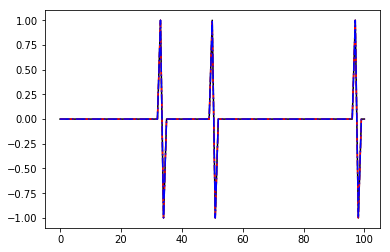

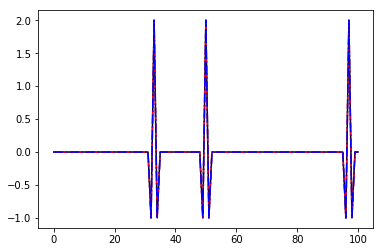

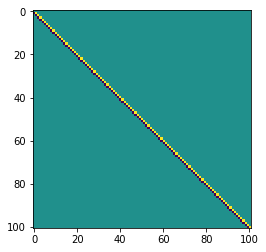

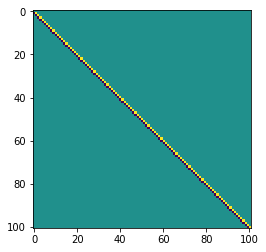

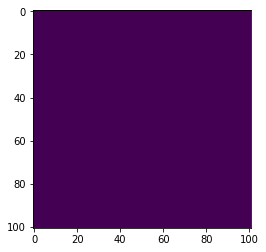

In [36]:
nx = 101
x = np.zeros(nx)
x[nx//2] = 1
x[nx//3] = 1
x[nx-4] = 1

Dop = FirstDerivative(nx, kind='backward')
Dconvop = Convolve1D(nx, np.array([1, -1]), offset=0)
Dsparse = sparse.diags([-1, 1], [-1, 0], shape=(nx, nx)).tocsr()
Dsparse[0, :] = 0

dottest(Dop, nx, nx, verb=True)

y = Dop*x
yconv = Dconvop*x
ysparse = Dsparse@x

xadj = Dop.H*y
xadjconv = Dconvop.H*y
xadjsparse = Dsparse.T@y

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

print(np.allclose(y, ysparse))
print(np.allclose(xadj, xadjsparse))

plt.figure()
plt.plot(y, 'k')
plt.plot(yconv, '--r')
plt.plot(ysparse, '-.b')

plt.figure()
plt.plot(xadj, 'k')
plt.plot(xadjconv, '--r')
plt.plot(xadjsparse, '-.b')

plt.figure()
plt.imshow(Dsparse.todense());

plt.figure()
plt.imshow(Dop.todense());

plt.figure()
plt.imshow(Dsparse.todense()-Dop.todense());

In [10]:
from scipy import sparse
domain_shape = (5, 10)

dx = sparse.diags([1, -1], [0, 1], shape=(domain_shape[1], domain_shape[1])).tocsr()
dx[domain_shape[1] - 1, :] = 0
dy = sparse.diags([-1, 1], [0, 1], shape=(domain_shape[0], domain_shape[0])).tocsr()
dy[domain_shape[0] - 1, :] = 0

In [11]:
dx.todense()

matrix([[ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [12]:
dy.todense()

matrix([[-1.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.]])

In [61]:
from scipy import sparse
domain_shape = (5, 10)

dforw = sparse.diags([-1, 1], [0, 1], shape=(domain_shape[1], domain_shape[1])).tocsr()
dforw[domain_shape[1] - 1, :] = 0
dback = sparse.diags([-1, 1], [-1, 0], shape=(domain_shape[0], domain_shape[0])).tocsr()
dback[0, :] = 0

In [62]:
dforw.todense()

matrix([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [63]:
dback.todense()

matrix([[ 0.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0., -1.,  1.]])